In [2]:
import pandas as pd
from glob import glob
import numpy as np
import scipy as sp
import mne
from os import path as op
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import *
from utils.classifiers import *

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split,permutation_test_score
from xgboost import XGBClassifier, XGBRegressor


/home/groups/jyeatman/software/ethanroy/envs/mne/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [13]:
subs_dict['ENI_032']['X'].shape

(800, 46500)

In [8]:
# load data
data_dir = '/scratch/users/ethanroy/eeg_groupitizing_data/classification_input/'
pilot2_dir = op.join(data_dir, 'pilot_2')
synapse_dir = op.join(data_dir, 'pilot_2')

subs = ['ENI_032', "ENI_195", "BLC_1043_2"]
subs_dict = {}

for sub in subs:
    print(f"Loading data for {sub}")
    # Load data for pilot 1
    if 'BLC' in sub:
                subs_dict[sub] = load_data(f'{sub}.mat', synapse_dir)
    else:
        subs_dict[sub] = load_data(f'{sub}.mat', pilot2_dir)

    # classify numerosity overall
    
    subs_dict[sub]['labels_trial_idx'] = np.array([i%5 + 1 for i in range(subs_dict[sub]['X'].shape[0])])
    subs_dict[sub]['pairwise_results'] = run_pairwise_classification_cv(subs_dict[sub], 'labels_numerosity')
    subs_dict[sub]['pairwise_stim_idx_results'] = run_pairwise_classification_cv(subs_dict[sub], 'labels_trial_idx')

    
    # classify answer from operands
    subs_dict[sub]['pairwise_results_operands'] = run_pairwise_classification_cv(subs_dict[sub], 'labels_sum')
    
    # classify answer from equals sign
    subs_dict[sub]['pairwise_results_sum_eq'] = run_pairwise_classification_cv(subs_dict[sub], 'eq_sum')

    # cross-modal predictions of operand numerosity training on either dots or digits 
    pairwise_results_train_dots, pairwise_results_train_digits = run_pairwise_crossformat_classification(subs_dict[sub],'labels_numerosity')

    subs_dict[sub]['pairwise_results_train_dots'] = pairwise_results_train_dots
    subs_dict[sub]['pairwise_results_train_digits'] = pairwise_results_train_digits

    # cross-modal predictions of solution training on operands
    pairwise_results_train_dots_sum, pairwise_results_train_digits_sum = run_pairwise_crossformat_classification(subs_dict[sub],'labels_sum')

    subs_dict[sub]['pairwise_results_train_dots_sum'] = pairwise_results_train_dots_sum
    subs_dict[sub]['pairwise_results_train_digits_sum'] = pairwise_results_train_digits_sum

    # cross-modal predictions of solution training on either dots or digits at '='
    pairwise_results_eq_train_dots, pairwise_results_eq_train_digits = run_pairwise_crossformat_classification(subs_dict[sub], 'eq_sum')
    subs_dict[sub]['pairwise_results_eq_train_dots'] = pairwise_results_eq_train_dots
    subs_dict[sub]['pairwise_results_eq_train_digits'] = pairwise_results_eq_train_digits
    
    subs_dict[sub]['pairwise_uni_results_digits'] = run_pairwise_uni_classification_cv(subs_dict[sub],'labels_numerosity','digits')
    subs_dict[sub]['pairwise_uni_results_dots'] = run_pairwise_uni_classification_cv(subs_dict[sub],'labels_numerosity','dots')




Loading data for ENI_032


100%|██████████| 21/21 [00:28<00:00,  1.36s/it]


Loading data for ENI_195


100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


Loading data for BLC_1043_2


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


In [11]:
subs = ['ENI_032', "ENI_195", "BLC_1043_2"]

for sub in subs:
#     subs_dict[sub]['labels_trial_idx'] = np.array([i%5 + 1 for i in range(subs_dict[sub]['X'].shape[0])])
    subs_dict[sub]['pairwise_stim_idx_results'] = run_pairwise_classification_cv(subs_dict[sub], 'labels_trial_idx')
    
    

100%|██████████| 10/10 [02:00<00:00, 12.05s/it]


In [4]:
for sub in subs:

    subs_dict[sub]['pairwise_uni_results_digits'] = run_pairwise_uni_classification_cv(subs_dict[sub],'labels_numerosity','digits')
    subs_dict[sub]['pairwise_uni_results_dots'] = run_pairwise_uni_classification_cv(subs_dict[sub],'labels_numerosity','dots')

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


In [9]:
import pickle

outpath = '/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/data/classification_data/classification_results'

with open(op.join(outpath,'classification_data.pkl'), 'wb') as f:
        pickle.dump(subs_dict, f)

In [5]:
# Get average test scores for each pair

mean_pairwise_crossmodeal_results = {}

for key in subs_dict[sub]['pairwise_results_train_digits'].keys():

    mean_pairwise_crossmodeal_results[key] = {}
    train_digits_scores = np.array([])
    train_dots_scores = np.array([])

    for sub in subs:
        train_digits_scores = np.append(train_digits_scores,subs_dict[sub]['pairwise_results_train_digits'][key]['test_score'])
        train_dots_scores = np.append(train_dots_scores, subs_dict[sub]['pairwise_results_train_dots'][key]['test_score'])


    mean_pairwise_crossmodeal_results[key]['train_digits_score'] = np.mean(train_digits_scores)
    mean_pairwise_crossmodeal_results[key]['train_dots_score'] = np.mean(train_dots_scores)



In [18]:
mean_pairwise_stim_pos_results

{'1_2': {'mean_accuracy': np.float64(0.75)},
 '1_3': {'mean_accuracy': np.float64(0.60625)},
 '1_4': {'mean_accuracy': np.float64(0.8375)},
 '1_5': {'mean_accuracy': np.float64(0.70625)},
 '2_3': {'mean_accuracy': np.float64(0.59375)},
 '2_4': {'mean_accuracy': np.float64(0.60625)},
 '2_5': {'mean_accuracy': np.float64(0.7625)},
 '3_4': {'mean_accuracy': np.float64(0.65)},
 '3_5': {'mean_accuracy': np.float64(0.634375)},
 '4_5': {'mean_accuracy': np.float64(0.775)}}

dict_keys(['X', 'X_3d', 'X_multi', 'n_samples', 'good_epochs', 'labels3', 'labels_numerosity', 'labels_range', 'labels_sum', 'labels_correct', 'eq_idx', 'op_1_idx', 'op_2_idx', 'solution_idx', 'trial_format', 'labels_trial_idx', 'pairwise_results', 'pairwise_results_operands', 'pairwise_results_sum_eq', 'pairwise_results_train_dots', 'pairwise_results_train_digits', 'pairwise_results_train_dots_sum', 'pairwise_results_train_digits_sum', 'pairwise_results_eq_train_dots', 'pairwise_results_eq_train_digits', 'pairwise_uni_results_digits', 'pairwise_uni_results_dots'])

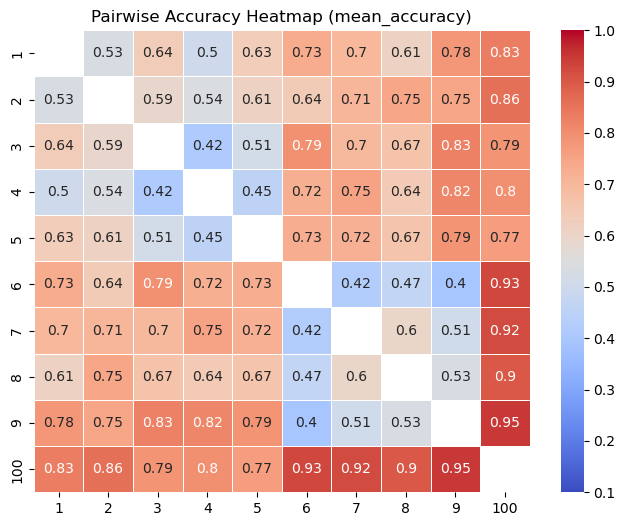

,1,2,3,4,5,6,7,8,9,100
1,NaN,0.529545,0.636667,0.503810,0.631250,0.730556,0.701111,0.610000,0.780556,0.831309
2,0.529545,NaN,0.589048,0.538462,0.614286,0.639286,0.705357,0.745833,0.750000,0.856757
3,0.636667,0.589048,NaN,0.416013,0.513743,0.793182,0.696970,0.666667,0.825455,0.788386
4,0.503810,0.538462,0.416013,NaN,0.452941,0.724545,0.751818,0.643939,0.816667,0.797500
5,0.631250,0.614286,0.513743,0.452941,NaN,0.728788,0.721970,0.665385,0.787273,0.765854
6,0.730556,0.639286,0.793182,0.724545,0.728788,NaN,0.420000,0.466667,0.395000,0.927479
7,0.701111,0.705357,0.696970,0.751818,0.721970,0.420000,NaN,0.597619,0.505000,0.922521
8,0.610000,0.745833,0.666667,0.643939,0.665385,0.466667,0.597619,NaN,0.530000,0.898730
9,0.780556,0.750000,0.825455,0.816667,0.787273,0.395000,0.505000,0.530000,NaN,0.949733
100,0.831309,0.856757,0.788386,0.797500,0.765854,0.927479,0.922521,0.898730,0.949733,NaN


In [7]:
# Get average test scores for each pair of stim positions

mean_pairwise_stim_pos_results = {}

for key in subs_dict[sub]['pairwise_results'].keys():

    mean_pairwise_stim_pos_results[key] = {}
    train_digits_scores = np.array([])

    for sub in subs:
        test_scores = np.append(train_digits_scores,subs_dict[sub]['pairwise_results'][key]['xgb_mean_accuracy'])


    mean_pairwise_stim_pos_results[key]['mean_accuracy'] = np.mean(test_scores)
    
plot_AM(mean_pairwise_stim_pos_results, metric='mean_accuracy')

In [7]:
# Get average test scores for each pair

mean_pairwise_crossmodeal_results_eq = {}

for key in subs_dict[sub]['pairwise_results_eq_train_dots'].keys():

    mean_pairwise_crossmodeal_results_eq[key] = {}
    train_digits_scores = np.array([])
    train_dots_scores = np.array([])

    for sub in subs:
        train_digits_scores = np.append(train_digits_scores,subs_dict[sub]['pairwise_results_eq_train_digits'][key]['test_score'])
        train_dots_scores = np.append(train_dots_scores, subs_dict[sub]['pairwise_results_eq_train_dots'][key]['test_score'])


    mean_pairwise_crossmodeal_results_eq[key]['train_digits_score'] = np.mean(train_digits_scores)
    mean_pairwise_crossmodeal_results_eq[key]['train_dots_score'] = np.mean(train_dots_scores)

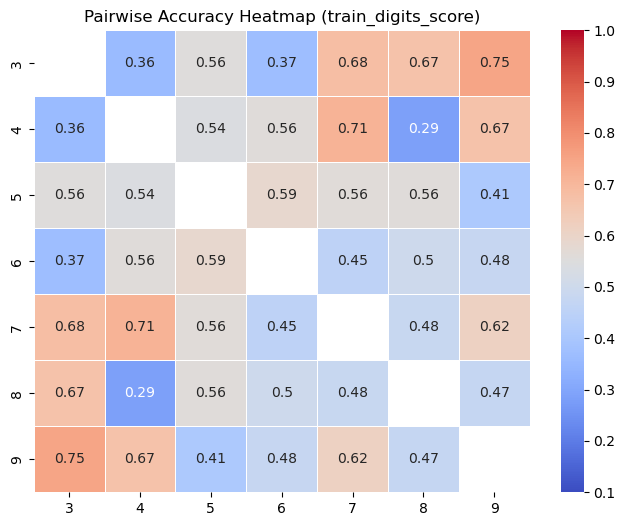

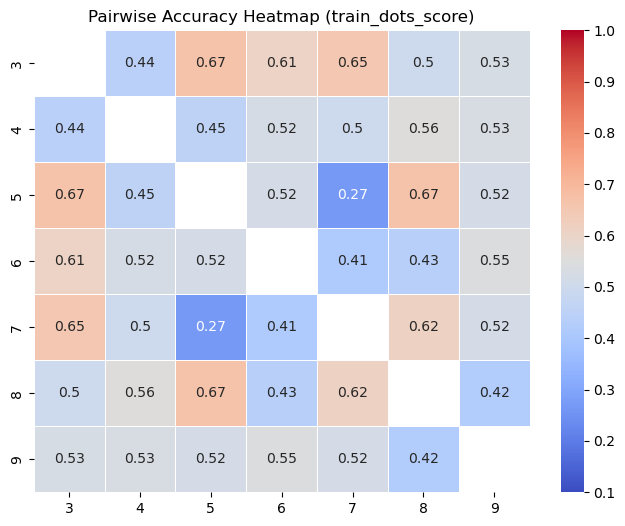

,3,4,5,6,7,8,9
3,NaN,0.444444,0.666667,0.608696,0.653846,0.500000,0.526316
4,0.444444,NaN,0.454545,0.523810,0.500000,0.555556,0.529412
5,0.666667,0.454545,NaN,0.518519,0.266667,0.666667,0.521739
6,0.608696,0.523810,0.518519,NaN,0.413793,0.434783,0.545455
7,0.653846,0.500000,0.266667,0.413793,NaN,0.615385,0.520000
8,0.500000,0.555556,0.666667,0.434783,0.615385,NaN,0.421053
9,0.526316,0.529412,0.521739,0.545455,0.520000,0.421053,NaN


In [8]:
# Predict generalization from equals sign

plot_AM(mean_pairwise_crossmodeal_results_eq, metric='train_digits_score')
plot_AM(mean_pairwise_crossmodeal_results_eq, metric='train_dots_score')

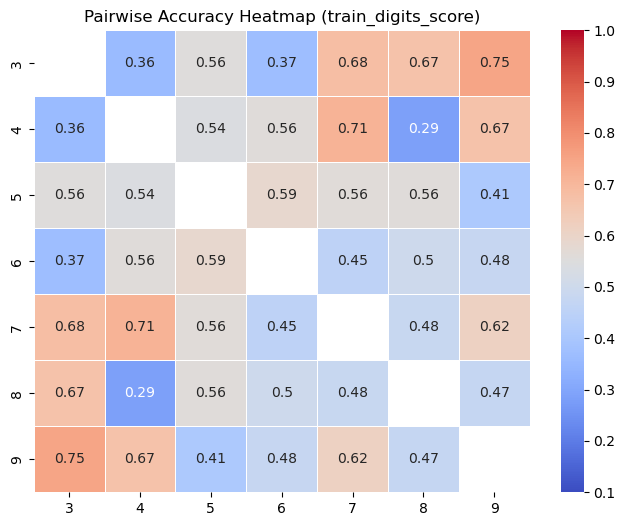

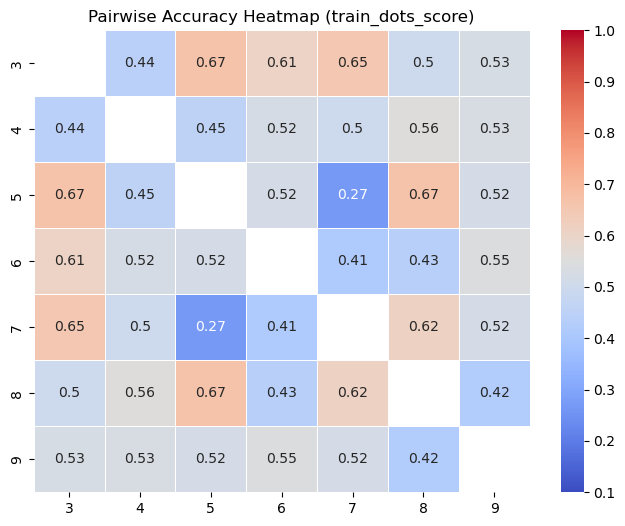

,3,4,5,6,7,8,9
3,NaN,0.444444,0.666667,0.608696,0.653846,0.500000,0.526316
4,0.444444,NaN,0.454545,0.523810,0.500000,0.555556,0.529412
5,0.666667,0.454545,NaN,0.518519,0.266667,0.666667,0.521739
6,0.608696,0.523810,0.518519,NaN,0.413793,0.434783,0.545455
7,0.653846,0.500000,0.266667,0.413793,NaN,0.615385,0.520000
8,0.500000,0.555556,0.666667,0.434783,0.615385,NaN,0.421053
9,0.526316,0.529412,0.521739,0.545455,0.520000,0.421053,NaN


In [9]:
# Predict sum generalization training on operands (1-5)

plot_AM(mean_pairwise_crossmodeal_results,metric='train_digits_score')
plot_AM(mean_pairwise_crossmodeal_results,metric='train_dots_score')

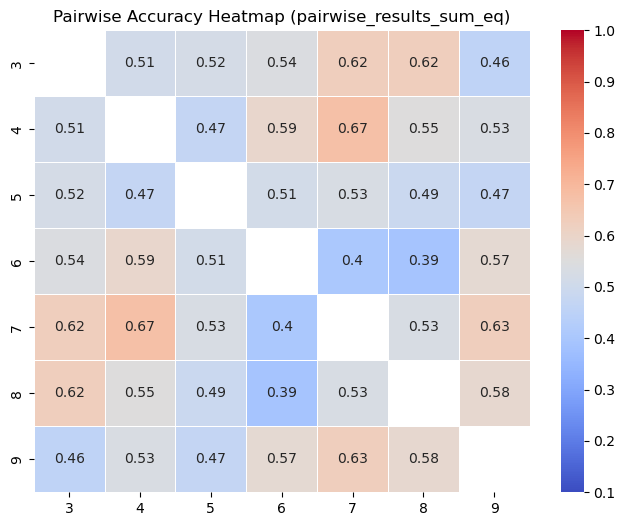

,3,4,5,6,7,8,9
3,NaN,0.508333,0.520000,0.540000,0.625000,0.625000,0.458333
4,0.508333,NaN,0.470000,0.590000,0.673333,0.550000,0.533333
5,0.520000,0.470000,NaN,0.513333,0.530952,0.490000,0.470000
6,0.540000,0.590000,0.513333,NaN,0.402381,0.390000,0.575000
7,0.625000,0.673333,0.530952,0.402381,NaN,0.530000,0.626667
8,0.625000,0.550000,0.490000,0.390000,0.530000,NaN,0.583333
9,0.458333,0.533333,0.470000,0.575000,0.626667,0.583333,NaN


In [10]:
mean_pairwise_eq_results = {}

for key in subs_dict[sub]['pairwise_results_sum_eq'].keys():

    mean_pairwise_eq_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_results_sum_eq'][key]['xgb_mean_accuracy'])


    mean_pairwise_eq_results[key]['pairwise_results_sum_eq'] = np.mean(scores)

plot_AM(mean_pairwise_eq_results, metric='pairwise_results_sum_eq')

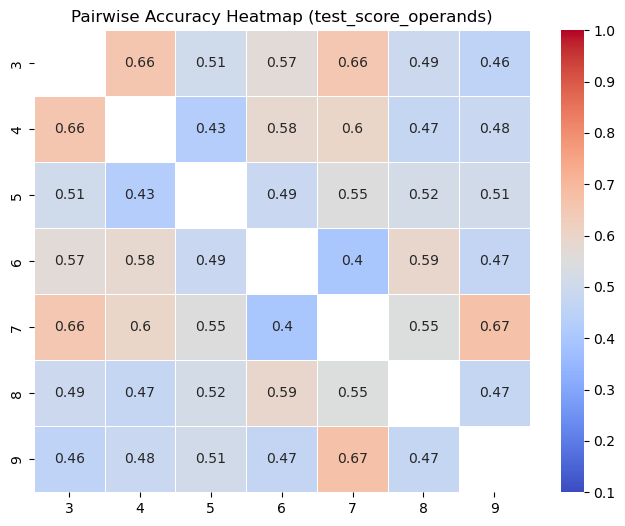

,3,4,5,6,7,8,9
3,NaN,0.658333,0.505000,0.565000,0.655000,0.491667,0.458333
4,0.658333,NaN,0.430000,0.585000,0.596667,0.475000,0.483333
5,0.505000,0.430000,NaN,0.486667,0.552381,0.515000,0.510000
6,0.565000,0.585000,0.486667,NaN,0.400000,0.590000,0.470000
7,0.655000,0.596667,0.552381,0.400000,NaN,0.546667,0.670000
8,0.491667,0.475000,0.515000,0.590000,0.546667,NaN,0.475000
9,0.458333,0.483333,0.510000,0.470000,0.670000,0.475000,NaN


In [11]:
# Get average test scores for each pair

mean_pairwise_results = {}

for key in subs_dict[sub]['pairwise_results_operands'].keys():

    mean_pairwise_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_results_operands'][key]['xgb_mean_accuracy'])


    mean_pairwise_results[key]['test_score_operands'] = np.mean(scores)

plot_AM(mean_pairwise_results, metric='test_score_operands')

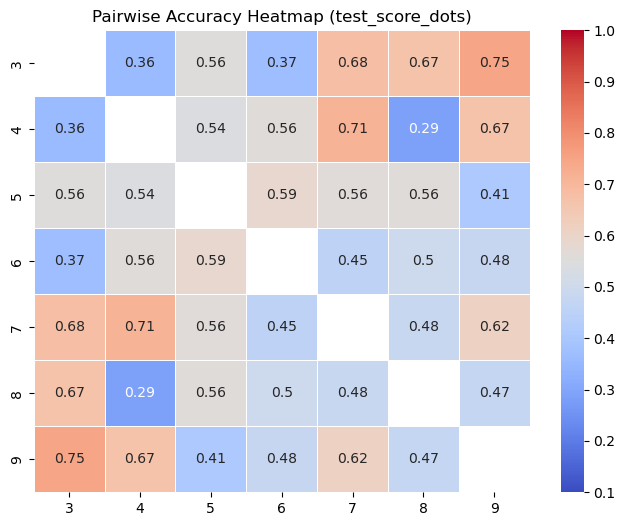

,3,4,5,6,7,8,9
3,NaN,0.357143,0.555556,0.368421,0.681818,0.666667,0.750000
4,0.357143,NaN,0.541667,0.560000,0.714286,0.285714,0.666667
5,0.555556,0.541667,NaN,0.586207,0.562500,0.560000,0.409091
6,0.368421,0.560000,0.586207,NaN,0.454545,0.500000,0.478261
7,0.681818,0.714286,0.562500,0.454545,NaN,0.482759,0.615385
8,0.666667,0.285714,0.560000,0.500000,0.482759,NaN,0.473684
9,0.750000,0.666667,0.409091,0.478261,0.615385,0.473684,NaN


In [12]:
# Get average test scores for each pair

mean_pairwise_results = {}

for key in subs_dict[sub]['pairwise_results_eq_train_digits'].keys():

    mean_pairwise_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_results_eq_train_digits'][key]['test_score'])


    mean_pairwise_results[key]['test_score_dots'] = np.mean(scores)

plot_AM(mean_pairwise_results, metric='test_score_dots')

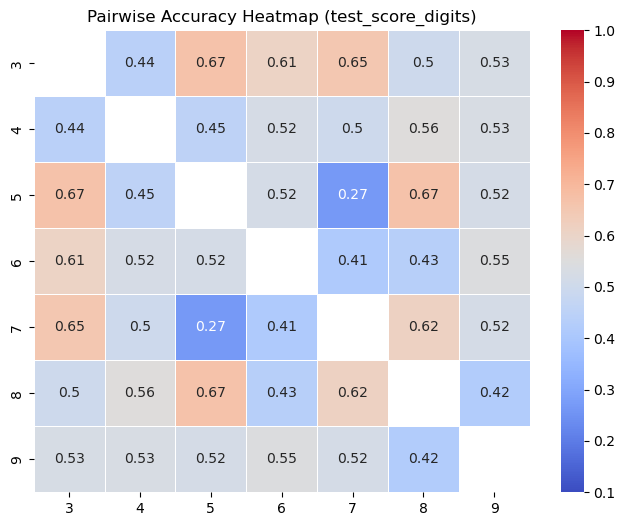

In [13]:
# Get average test scores for each pair

mean_pairwise_results = {}

for key in subs_dict[sub]['pairwise_results_eq_train_dots'].keys():

    mean_pairwise_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_results_eq_train_dots'][key]['test_score'])


    mean_pairwise_results[key]['test_score_digits'] = np.mean(scores)

test_digits = plot_AM(mean_pairwise_results, metric='test_score_digits')
test_digits.to_csv('/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/data/classification_data/numerosity_results/xgb_sol_test_digit_acc_pilot2.csv',
                   index=False)

In [14]:
# Get average test scores for each pair

mean_pairwise_results = {}

for key in subs_dict[sub]['pairwise_results'].keys():

    mean_pairwise_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_results'][key]['xgb_mean_accuracy'])


    mean_pairwise_results[key]['test_score'] = np.mean(scores)


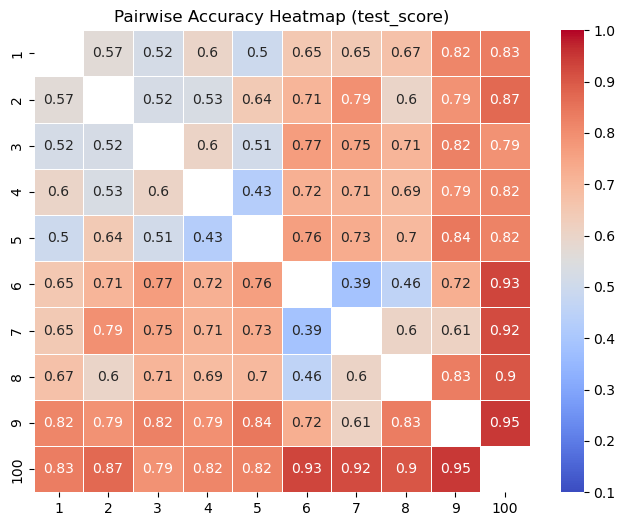

In [15]:
test = plot_AM(mean_pairwise_results, metric='test_score')

In [16]:
test = test.fillna(0)
test.iloc[0:9,0:9]

,1,2,3,4,5,6,7,8,9
1,0.000000,0.565909,0.519167,0.601905,0.497083,0.651389,0.645556,0.670000,0.816667
2,0.565909,0.000000,0.524286,0.530769,0.642857,0.705357,0.794643,0.600000,0.790476
3,0.519167,0.524286,0.000000,0.603268,0.508187,0.765152,0.748485,0.707692,0.824545
4,0.601905,0.530769,0.603268,0.000000,0.429412,0.720909,0.712727,0.687121,0.794444
5,0.497083,0.642857,0.508187,0.429412,0.000000,0.764394,0.730303,0.696154,0.842727
6,0.651389,0.705357,0.765152,0.720909,0.764394,0.000000,0.386667,0.456667,0.725000
7,0.645556,0.794643,0.748485,0.712727,0.730303,0.386667,0.000000,0.604762,0.610000
8,0.670000,0.600000,0.707692,0.687121,0.696154,0.456667,0.604762,0.000000,0.833333
9,0.816667,0.790476,0.824545,0.794444,0.842727,0.725000,0.610000,0.833333,0.000000


In [52]:
test.iloc[0:9,0:9].to_csv('/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/data/classification_data/numerosity_results/xgb_pairwise_acc_pilot2.txt',index=False,header=False)

In [58]:
subs_dict['ENI_032'].keys()

dict_keys(['X', 'X_multi', 'labels3', 'labels_numerosity', 'labels_range', 'labels_sum', 'labels_correct', 'eq_idx', 'solution_idx', 'trial_format', 'pairwise_results', 'pairwise_results_operands', 'pairwise_results_sum_eq', 'pairwise_results_train_dots', 'pairwise_results_train_digits', 'pairwise_results_train_dots_sum', 'pairwise_results_train_digits_sum', 'pairwise_results_eq_train_dots', 'pairwise_results_eq_train_digits', 'pairwise_uni_results_digits', 'pairwise_uni_results_dots'])

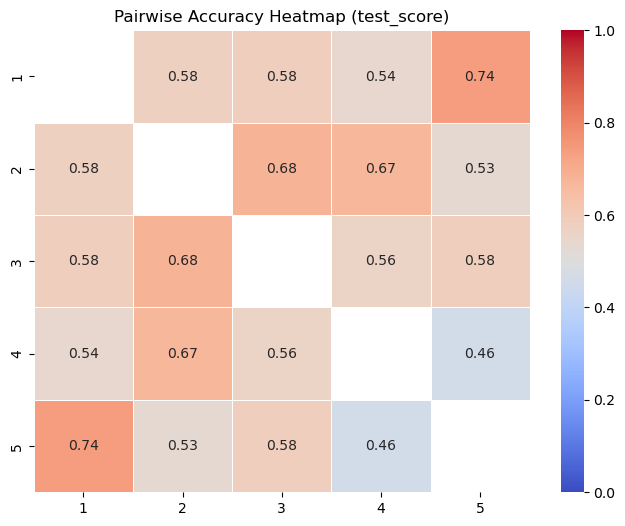

In [61]:
mean_pairwise_results = {}

for key in subs_dict[sub]['pairwise_uni_results_dots'].keys():

    mean_pairwise_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_uni_results_dots'][key]['xgb_mean_accuracy'])


    mean_pairwise_results[key]['test_score'] = np.mean(scores)


test_dots = plot_AM(mean_pairwise_results, metric='test_score')

In [65]:
test_dots = test_dots.fillna(0)
test_dots.to_csv('/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/data/classification_data/numerosity_results/xgb_pairwise_dots_acc_pilot2.txt',index=False,header=False)

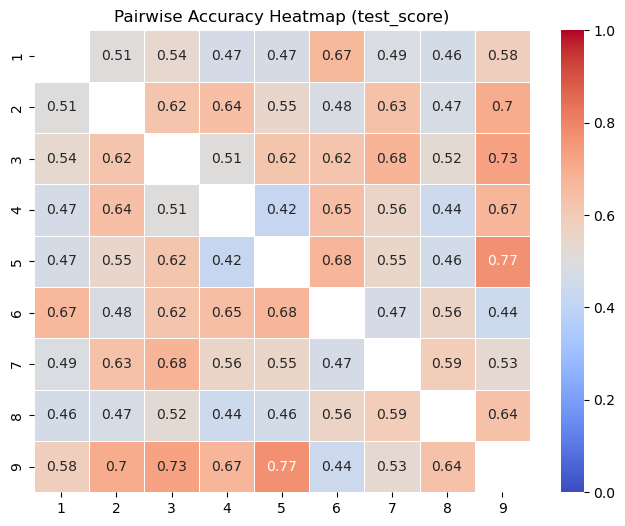

In [69]:
mean_pairwise_results = {}

for key in subs_dict[sub]['pairwise_uni_results_digits'].keys():

    mean_pairwise_results[key] = {}
    test_score = np.array([])

    for sub in subs:
        scores = np.append(test_score,subs_dict[sub]['pairwise_uni_results_digits'][key]['xgb_mean_accuracy'])


    mean_pairwise_results[key]['test_score'] = np.mean(scores)

test_digits = plot_AM(mean_pairwise_results, metric='test_score')

In [70]:
test_digits = test_digits.fillna(0)
test_digits.to_csv('/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/data/classification_data/numerosity_results/xgb_pairwise_digits_acc_pilot2.txt',index=False,header=False)

In [1]:
from glob import glob

In [5]:
files = glob('/Users/ethanroy/Documents/Stanford/EdNeuro/eeg_groupitizing/code/image_processing/*block*.csv')

trials_df = pd.DataFrame()

for file in files:

    if 'shorter' not in file:
        trials_df = pd.concat([trials_df, pd.read_csv(file)])


In [9]:
trials_df[['operand_1','operand_2','solution','correct','form']].to_csv("trial_info.csv")